In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import random
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch
import torch.nn
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.utils import make_grid
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [34]:
class config:
    ROOT = "HR_DATA"
    SAVE_MODEL = True
    CHECKPOINT_GEN = "model/gen.pth"
    CHECKPOINT_DISC = "model/disc.pth"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 16
    LAMBDA_GP = 10
    NUM_WORKERS = 4
    HIGH_RES = 256
    LOW_RES = HIGH_RES // 4
    IMG_CHANNELS = 3
    EPOCHS = 30

    highres_transform = A.Compose(
        [
            A.Resize(width=HIGH_RES, height=HIGH_RES, interpolation=Image.BICUBIC),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            ToTensorV2(),
        ]
    )

    lowres_transform = A.Compose(
        [
            A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            ToTensorV2(),
        ]
    )

In [8]:
data_files = os.listdir(config.ROOT)
data_files.sort()
data_files = [os.path.join(config.ROOT, file) for file in data_files]

df = pd.DataFrame(data_files, columns=["file_path"])
df.head()

,file_path
0,HR_DATA/0_180.png
1,HR_DATA/0_180_lr.png
2,HR_DATA/0_180_tb.png
3,HR_DATA/0_270.png
4,HR_DATA/0_270_lr.png


In [9]:
df.shape

(2300, 1)

In [10]:
train_df = df.sample(n=2000, random_state=seed)
val_df = df.drop(train_df.index)

train_df.shape, val_df.shape

((2000, 1), (300, 1))

In [11]:
class MyImageFolder(Dataset):
    def __init__(self, data):
        super(MyImageFolder, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = cv2.imread(self.data[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        high_res = config.highres_transform(image=image)["image"]
        low_res = config.lowres_transform(image=image)["image"]
        return low_res, high_res

In [12]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(weights='DEFAULT').features[:35].eval().to(config.DEVICE)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.loss = nn.MSELoss()

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))

In [14]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [15]:
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x

In [16]:
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x

In [17]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [19]:
def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [20]:
def save_checkpoint(model, optimizer, filename):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [21]:
def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

In [22]:
def display_images(generator, val_loader, device, title="Generated Images"):
    generator.eval()

    first_batch = next(iter(val_loader))
    low_res_samples = first_batch[0][:3].to(device)
    high_res_samples_original = first_batch[1][:3].to(device)

    with torch.no_grad():
        high_res_samples_generated = generator(low_res_samples)

    low_res_samples_np = low_res_samples.cpu().numpy()
    high_res_samples_original_np = high_res_samples_original.cpu().numpy()
    high_res_samples_generated_np = high_res_samples_generated.cpu().numpy()
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    for i in range(3):
        axs[i, 0].imshow(low_res_samples_np[i].transpose(1, 2, 0))
        axs[i, 0].set_title(f'Low-Res Image {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(high_res_samples_generated_np[i].transpose(1, 2, 0))
        axs[i, 1].set_title(f'Generated High-Res Image {i+1}')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(high_res_samples_original_np[i].transpose(1, 2, 0))
        axs[i, 2].set_title(f'Original High-Res Image {i+1}')
        axs[i, 2].axis('off')

    plt.suptitle(title)
    plt.show()

In [23]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, l1, vgg_loss, g_scaler, d_scaler, cur_epoch):
    total_critic_loss = 0.0
    total_gen_loss = 0.0
    total_l1_loss = 0.0
    total_vgg_loss = 0.0
    total_adversarial_loss = 0.0
    for idx, (low_res, high_res) in enumerate(loader):
        high_res = high_res.to(config.DEVICE)
        low_res = low_res.to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(low_res)
            critic_real = disc(high_res)
            critic_fake = disc(fake.detach())
            gp = gradient_penalty(disc, high_res, fake, device=config.DEVICE)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + config.LAMBDA_GP * gp)

        opt_disc.zero_grad()
        d_scaler.scale(loss_critic).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        with torch.cuda.amp.autocast():
            l1_loss = 1e-2 * l1(fake, high_res)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake))
            loss_for_vgg = vgg_loss(fake, high_res)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Accumulate losses for averaging
        total_critic_loss += loss_critic.item()
        total_l1_loss += l1_loss.item()
        total_vgg_loss += loss_for_vgg.item()
        total_adversarial_loss += adversarial_loss.item()
        total_gen_loss += gen_loss.item()

    # Calculate average losses
    avg_critic_loss = total_critic_loss / len(loader)
    avg_gen_loss = total_gen_loss / len(loader)
    avg_l1_loss = total_l1_loss / len(loader)
    avg_vgg_loss = total_vgg_loss / len(loader)
    avg_adversarial_loss = total_adversarial_loss / len(loader)

    # Print average losses to console
    print(f"Training => [{cur_epoch} / {config.EPOCHS}] | Generator Loss : {avg_gen_loss} | Discriminator Loss: {avg_critic_loss} | L1 Loss: {avg_l1_loss} | VGG Loss: {avg_vgg_loss} | Adversarial Loss: {avg_adversarial_loss}")

    return (avg_gen_loss, avg_critic_loss, avg_l1_loss, avg_vgg_loss, avg_adversarial_loss)

In [24]:
def validate_fn(loader, gen, disc, l1, vgg_loss, cur_epoch):
    gen.eval()
    disc.eval()

    total_critic_loss = 0.0
    total_gen_loss = 0.0
    total_l1_loss = 0.0
    total_vgg_loss = 0.0
    total_adversarial_loss = 0.0
    with torch.no_grad():
        for idx, (low_res, high_res) in enumerate(loader):
            high_res = high_res.to(config.DEVICE)
            low_res = low_res.to(config.DEVICE)
            fake = gen(low_res)
            critic_real = disc(high_res)
            critic_fake = disc(fake.detach())
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            # Calculate Validation Losses
            l1_loss = 1e-2 * l1(fake, high_res)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake))
            loss_for_vgg = vgg_loss(fake, high_res)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

            # Accumulate losses for averaging
            total_critic_loss += loss_critic.item()
            total_l1_loss += l1_loss.item()
            total_vgg_loss += loss_for_vgg.item()
            total_adversarial_loss += adversarial_loss.item()
            total_gen_loss += gen_loss.item()

    # Calculate average losses
    avg_critic_loss = total_critic_loss / len(loader)
    avg_gen_loss = total_gen_loss / len(loader)
    avg_l1_loss = total_l1_loss / len(loader)
    avg_vgg_loss = total_vgg_loss / len(loader)
    avg_adversarial_loss = total_adversarial_loss / len(loader)

    if (cur_epoch % 10) == 0:
        display_images(gen, loader, config.DEVICE, title="Generated Images from Validation Set")
    # Print average losses to console
    print(f"Validation => [{cur_epoch} / {config.EPOCHS}] | Generator Loss : {avg_gen_loss} | Discriminator Loss: {avg_critic_loss} | L1 Loss: {avg_l1_loss} | VGG Loss: {avg_vgg_loss} | Adversarial Loss: {avg_adversarial_loss}", "\n\n")
    gen.train()
    disc.train()

    return (avg_gen_loss, avg_critic_loss, avg_l1_loss, avg_vgg_loss, avg_adversarial_loss)

In [25]:
train_dataset = MyImageFolder(data=train_df["file_path"].values.tolist())
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=config.NUM_WORKERS,
)

In [26]:
val_dataset = MyImageFolder(data=val_df["file_path"].values.tolist())
val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=config.NUM_WORKERS,
)

In [27]:
gen = Generator(in_channels=3).to(config.DEVICE)
initialize_weights(gen)

In [28]:
print(gen)

Generator(
  (initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residuals): Sequential(
    (0): RRDB(
      (rrdb): Sequential(
        (0): DenseResidualBlock(
          (blocks): ModuleList(
            (0): ConvBlock(
              (cnn): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): ConvBlock(
              (cnn): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (2): ConvBlock(
              (cnn): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (3): ConvBlock(
              (cnn): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )


In [29]:
disc = Discriminator(in_channels=3).to(config.DEVICE)

In [30]:
print(disc)

Discriminator(
  (blocks): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): ConvBlock(
      (cnn): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): ConvBlock(
      (cnn): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inp

In [31]:
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))

In [32]:
l1 = nn.L1Loss()
vgg_loss = VGGLoss()
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 194MB/s]


In [33]:
history = {
    "Training": {
        "G_loss": [],
        "D_loss": [],
        "L1_loss": [],
        "VGG_loss": [],
        "Adversarial_loss": []
    },
    "Validation": {
        "G_loss": [],
        "D_loss": [],
        "L1_loss": [],
        "VGG_loss": [],
        "Adversarial_loss": []
    }
}

Training => [1 / 30] | Generator Loss : -inf | Discriminator Loss: inf | L1 Loss: 0.03655395499430597 | VGG Loss: 33.078711994171144 | Adversarial Loss: -inf
Validation => [1 / 30] | Generator Loss : 8.396777654948988 | Discriminator Loss: 66.7426687541761 | L1 Loss: 0.03788109339381519 | VGG Loss: 8.73145213880037 | Adversarial Loss: -0.37255562920319407 


Training => [2 / 30] | Generator Loss : 8.066869956970216 | Discriminator Loss: -13.006807815551758 | L1 Loss: 0.012241933493874967 | VGG Loss: 6.499485059738159 | Adversarial Loss: 1.5551429443359375
Validation => [2 / 30] | Generator Loss : 7.1529286033228825 | Discriminator Loss: -59.15837980571546 | L1 Loss: 0.0017081624031753133 | VGG Loss: 4.281235619595177 | Adversarial Loss: 2.8699847648018286 


Training => [3 / 30] | Generator Loss : 6.795343845367432 | Discriminator Loss: -34.1892123336792 | L1 Loss: 0.0021342046838253737 | VGG Loss: 3.407108087539673 | Adversarial Loss: 3.3861015625
Validation => [3 / 30] | Generator Lo

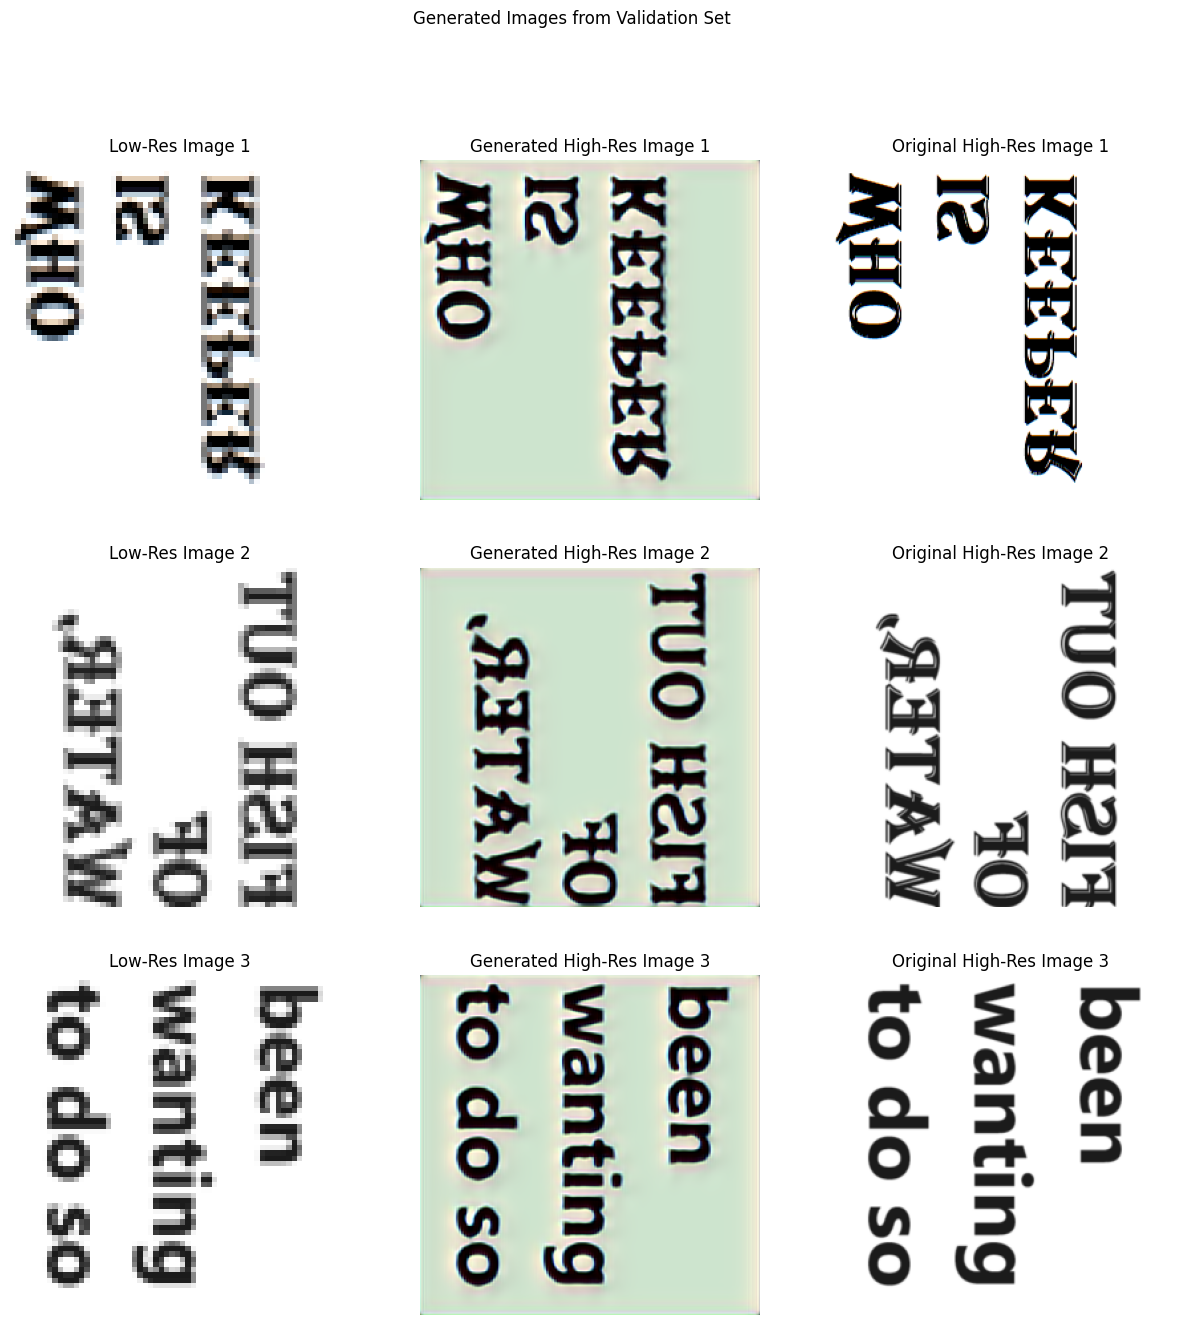

Validation => [10 / 30] | Generator Loss : 5.360156812165913 | Discriminator Loss: -58.67877839740954 | L1 Loss: 0.0014931089244782925 | VGG Loss: 0.8656817737378573 | Adversarial Loss: 4.492981910705566 


Saving models at epoch 10
Training => [11 / 30] | Generator Loss : 5.071432090759277 | Discriminator Loss: -33.76611616516113 | L1 Loss: 0.0010876577713061124 | VGG Loss: 0.7825006766319275 | Adversarial Loss: 4.28784375
Validation => [11 / 30] | Generator Loss : 4.4529844334251 | Discriminator Loss: -33.34681781969572 | L1 Loss: 0.0005344377775480481 | VGG Loss: 0.7835108386842828 | Adversarial Loss: 3.668939138713636 


Training => [12 / 30] | Generator Loss : 5.202106866836548 | Discriminator Loss: -34.74627143859863 | L1 Loss: 0.0010733117253985255 | VGG Loss: 0.7349397983551026 | Adversarial Loss: 4.46609375
Validation => [12 / 30] | Generator Loss : 3.6955821137679252 | Discriminator Loss: -34.76174123663651 | L1 Loss: 0.0005594417207727307 | VGG Loss: 0.6396878487185428 | Adv

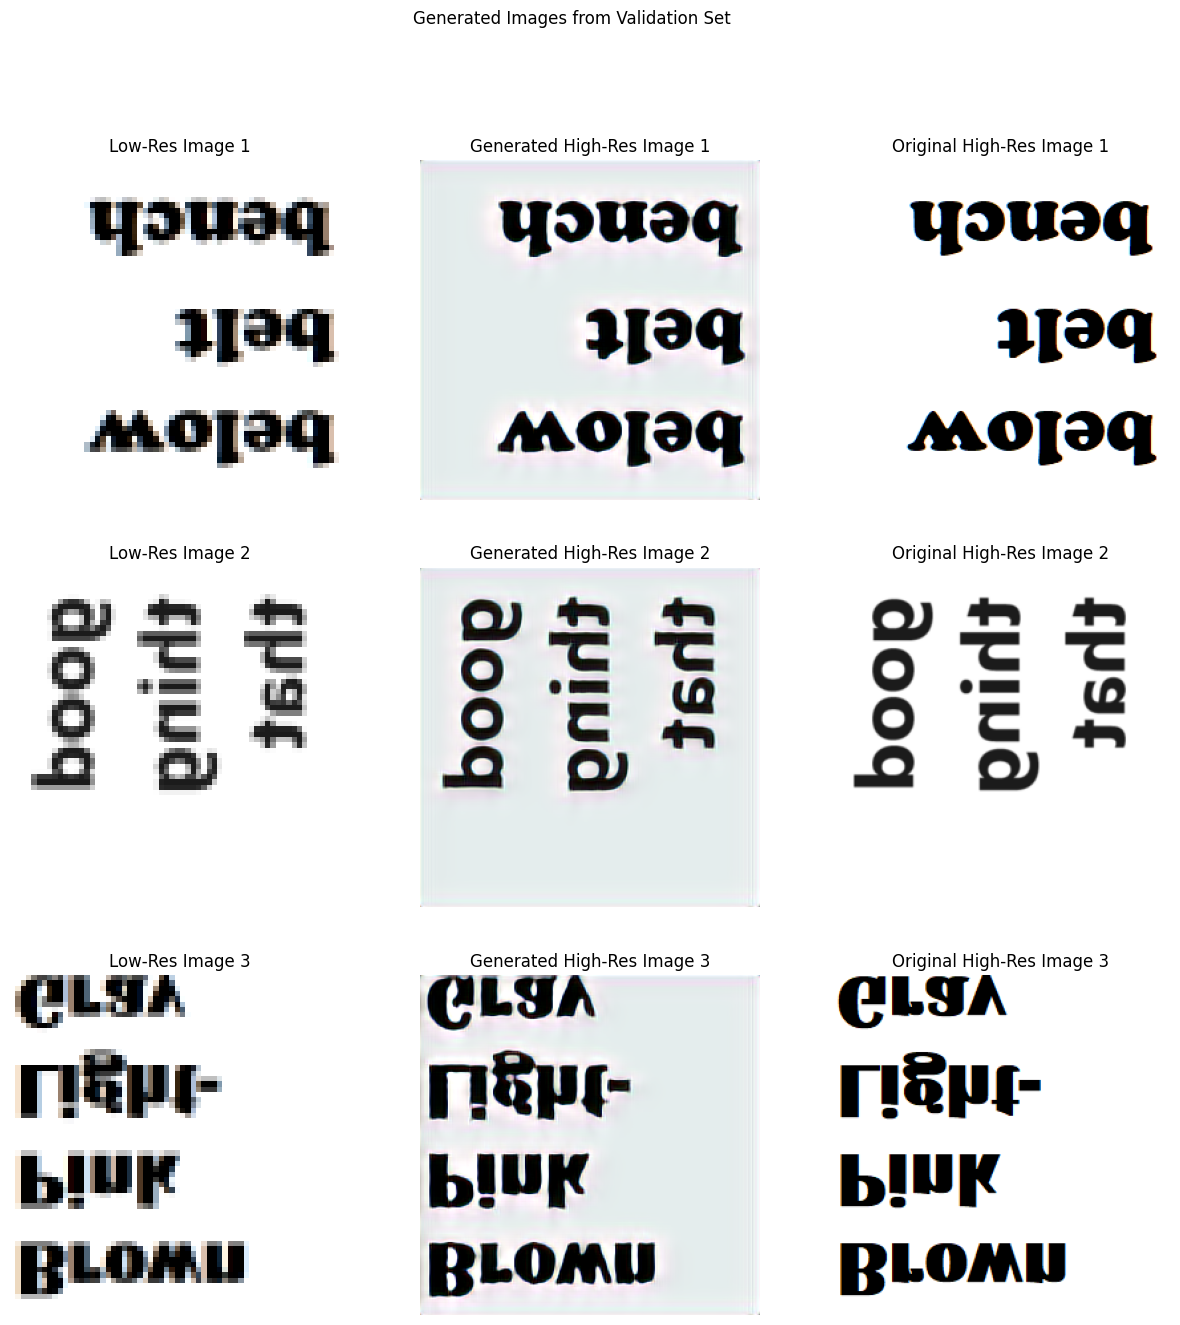

Validation => [20 / 30] | Generator Loss : 3.780928511368601 | Discriminator Loss: -20.52880859375 | L1 Loss: 0.0008108124939577752 | VGG Loss: 0.631393733777498 | Adversarial Loss: 3.1487239661969637 


Saving models at epoch 20
Training => [21 / 30] | Generator Loss : 4.245254741668701 | Discriminator Loss: -22.5313144493103 | L1 Loss: 0.0008416347377933562 | VGG Loss: 0.48785062503814697 | Adversarial Loss: 3.7565625
Validation => [21 / 30] | Generator Loss : 4.189554892088237 | Discriminator Loss: -28.208492881373356 | L1 Loss: 0.0006210461019930479 | VGG Loss: 0.4107892560331445 | Adversarial Loss: 3.778144585458856 


Training => [22 / 30] | Generator Loss : 4.088901739120484 | Discriminator Loss: -21.602731002807616 | L1 Loss: 0.0008236829165834933 | VGG Loss: 0.4600780546665192 | Adversarial Loss: 3.628
Validation => [22 / 30] | Generator Loss : 3.638361541848434 | Discriminator Loss: -24.7137162057977 | L1 Loss: 0.0007851311759287981 | VGG Loss: 0.5304717954836393 | Adversaria

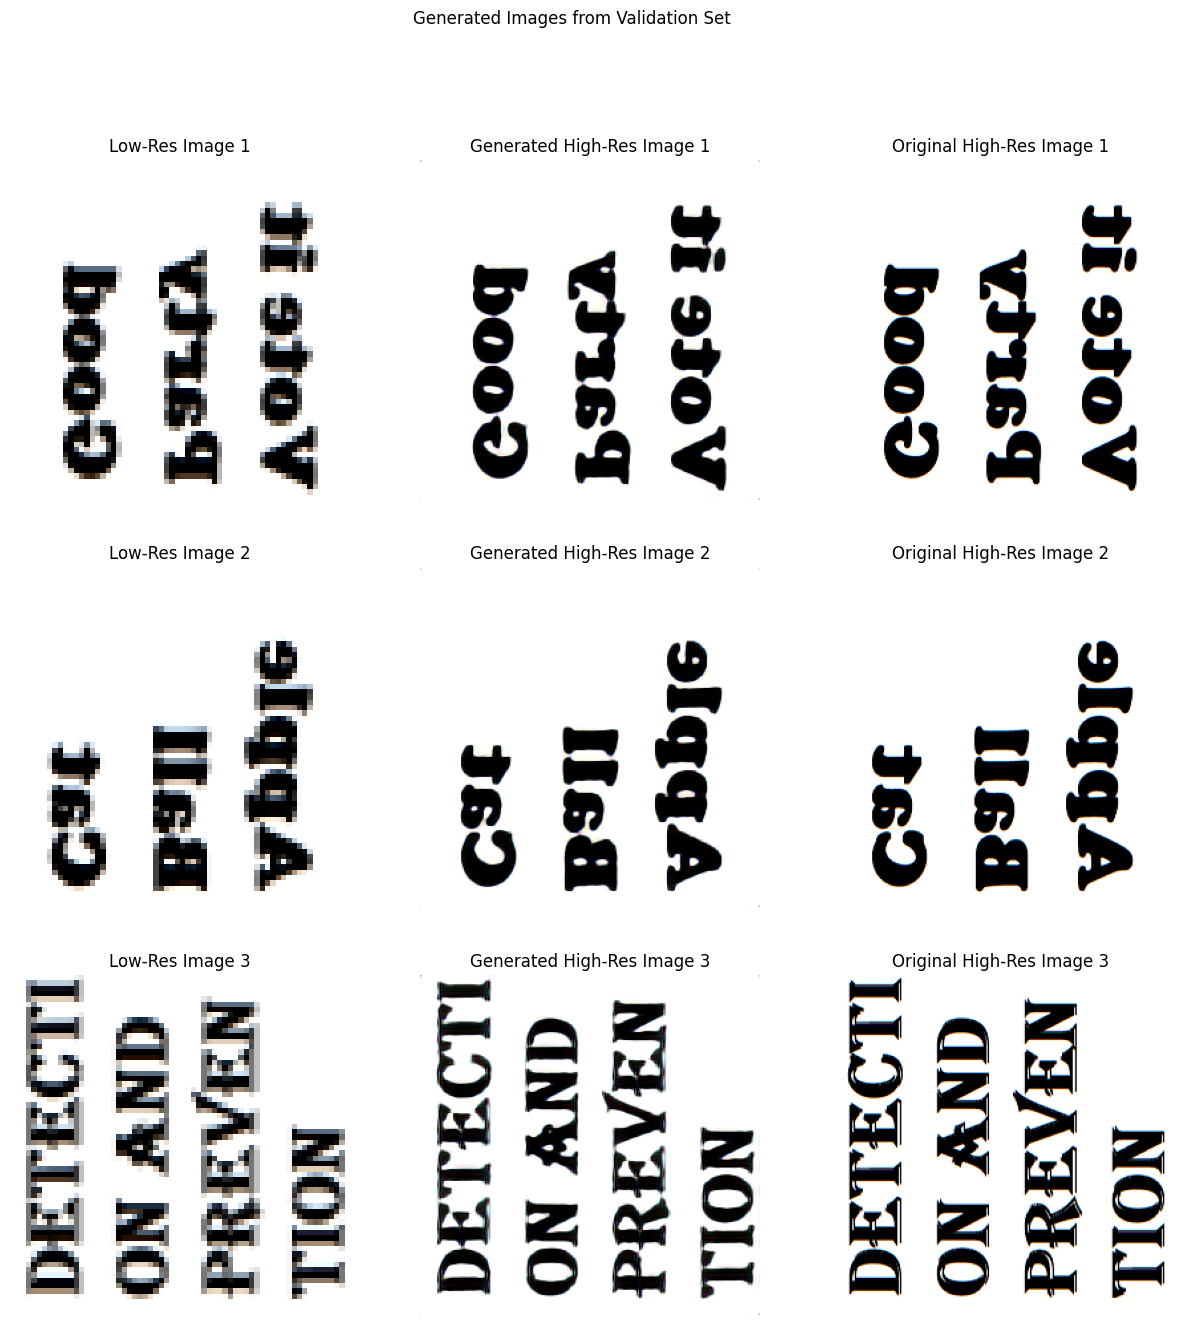

Validation => [30 / 30] | Generator Loss : 3.168280325437847 | Discriminator Loss: -36.993234734786185 | L1 Loss: 0.0007575765393037153 | VGG Loss: 0.3282263255433032 | Adversarial Loss: 2.8392964162324605 


Saving models at epoch 30


In [35]:
gen.train()
disc.train()

for epoch in range(1, config.EPOCHS+1):
    train_results = train_fn(train_loader, disc, gen, opt_gen, opt_disc, l1, vgg_loss, g_scaler, d_scaler, epoch)
    valid_results = validate_fn(val_loader, gen, disc, l1, vgg_loss, epoch)
    history["Training"]["G_loss"].append(train_results[0])
    history["Training"]["D_loss"].append(train_results[1])
    history["Training"]["L1_loss"].append(train_results[2])
    history["Training"]["VGG_loss"].append(train_results[3])
    history["Training"]["Adversarial_loss"].append(train_results[4])

    history["Validation"]["G_loss"].append(valid_results[0])
    history["Validation"]["D_loss"].append(valid_results[1])
    history["Validation"]["L1_loss"].append(valid_results[2])
    history["Validation"]["VGG_loss"].append(valid_results[3])
    history["Validation"]["Adversarial_loss"].append(valid_results[4])

    if (epoch) % 10 == 0:
        print(f"Saving models at epoch {epoch}")
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)

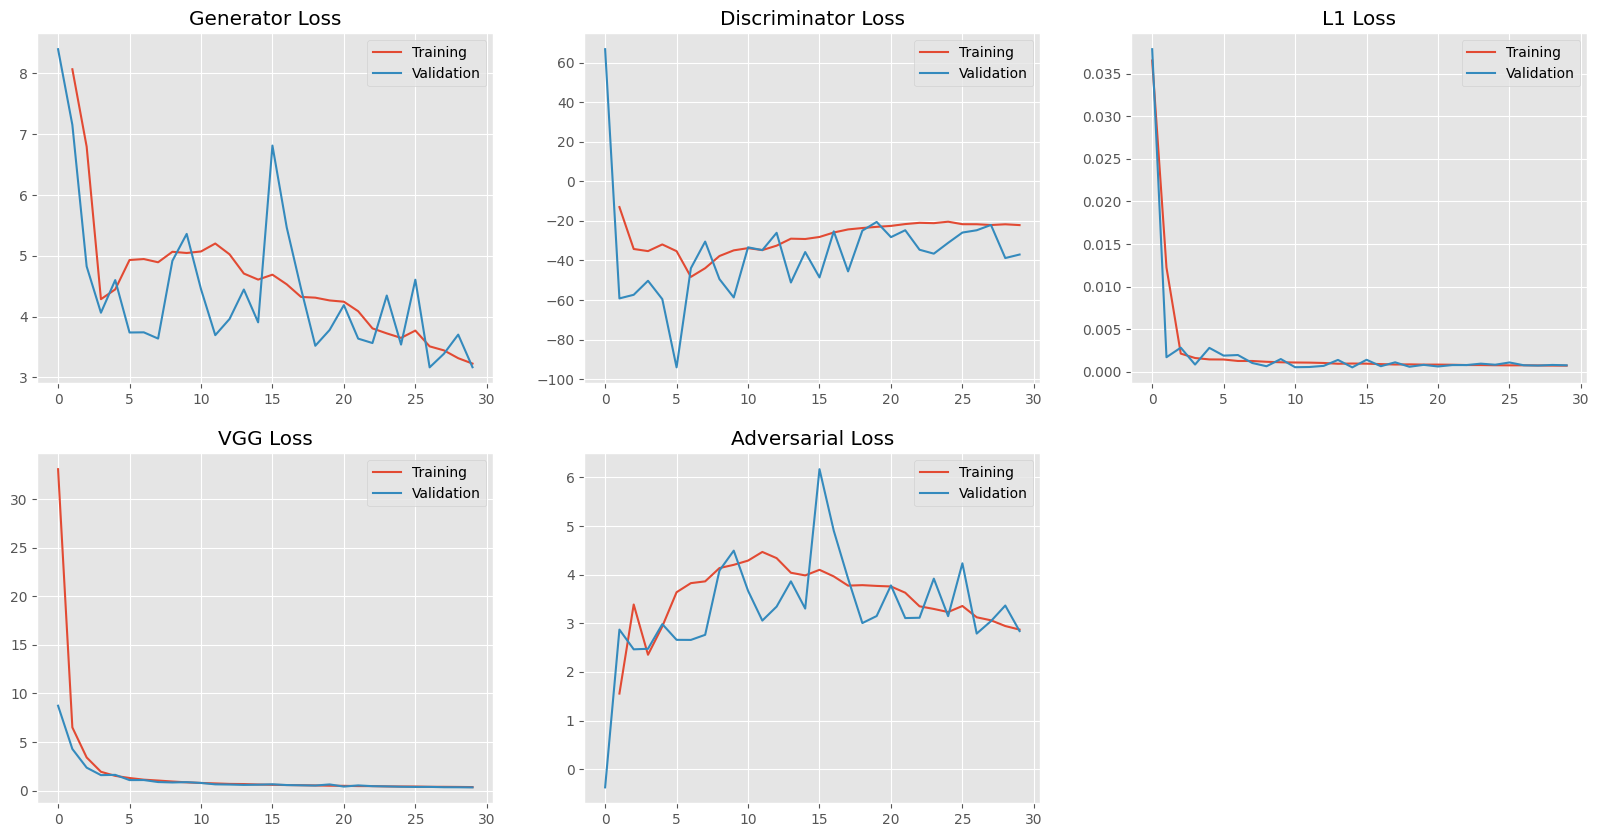

In [36]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    ax[0, 0].plot(history["Training"]["G_loss"], label="Training")
    ax[0, 0].plot(history["Validation"]["G_loss"], label="Validation")
    ax[0, 0].set_title("Generator Loss")
    ax[0, 0].legend()
    ax[0, 1].plot(history["Training"]["D_loss"], label="Training")
    ax[0, 1].plot(history["Validation"]["D_loss"], label="Validation")
    ax[0, 1].set_title("Discriminator Loss")
    ax[0, 1].legend()
    ax[0, 2].plot(history["Training"]["L1_loss"], label="Training")
    ax[0, 2].plot(history["Validation"]["L1_loss"], label="Validation")
    ax[0, 2].set_title("L1 Loss")
    ax[0, 2].legend()
    ax[1, 0].plot(history["Training"]["VGG_loss"], label="Training")
    ax[1, 0].plot(history["Validation"]["VGG_loss"], label="Validation")
    ax[1, 0].set_title("VGG Loss")
    ax[1, 0].legend()
    ax[1, 1].plot(history["Training"]["Adversarial_loss"], label="Training")
    ax[1, 1].plot(history["Validation"]["Adversarial_loss"], label="Validation")
    ax[1, 1].set_title("Adversarial Loss")
    ax[1, 1].legend()
    fig.delaxes(ax[1, 2])
    plt.savefig("loss.png")
    plt.show()